In [4]:
import json
import csv
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
modelfile = open('modelresponses.json')
modeldata = json.load(modelfile)
modelfile.close()

behexptf = open('3dp3behavior.json')
behexpt = json.load(behexptf)
behexptf.close()

In [6]:
def countModelAcc(modeldata):
    total_correct = 0
    allmodelvals = np.zeros((120))
    count = 1
    i = 0
    for id,acc in modeldata[0].items():
        total_correct += acc
        allmodelvals[int(id)-1] = acc
        
    return total_correct, allmodelvals

In [7]:
def getSubjectData(filename):
    with open(filename) as csvf:
        reader = csv.reader(csvf)
        subjects = {}
        i = 0
        for row in reader:
            if i == 0:
                names = [k for k in row]
                print(names)
            if i != 0:
                user_id = row[len(row)-1]
                if user_id != 'test':
                    if not user_id in subjects.keys():
                        subjects[user_id] = []
                    resp = {}
                    for j,val in enumerate(names):
                        resp[val] = row[j]
                    subjects[user_id].append(resp)
            i += 1
        return subjects
        csvf.close()

In [8]:
def matchSampleToID(samplename, expt):
    for trial in expt:
        if samplename != '':
            if trial['img_sample'] == ('./scenes' + samplename.split('.com')[1]):
                return trial['trialid'], trial['lure_type']

In [9]:
def getCorrectByLureCond(subjs):
    allLureTypes = np.zeros((len(subjs),120))
    for i,subj in enumerate(subjs):
        count = 0
        for trial,vals in subj.items():
            if count == 30:
                count = 0
            if vals['correct'] == 'True':
                allLureTypes[i,int(trial)-1] = 1
            count += 1
    return allLureTypes

In [10]:
subjects = getSubjectData('sceneGraph_classProject_data.csv')
allsubjdata = []
for subj, trials in subjects.items():
    subjdata = {}
    for trial in trials:
        if trial['img_sample'] != '':
            trialid, lure_type = matchSampleToID(trial['img_sample'], behexpt)
            trialdict = {}
            trialdict['correct'] = trial['correct']
            trialdict['img_target'] = trial['img_target']
            trialdict['img_lure'] = trial['img_target']
            trialdict['img_sample'] = trial['img_sample']
            trialdict['lure_type'] = lure_type
            subjdata[trialid] = trialdict
    allsubjdata.append(subjdata)

['', '_id', 'choices', 'correct', 'correct_choice', 'expName', 'gameid', 'img_lure', 'img_sample', 'img_target', 'index', 'inputid', 'internal_node_id', 'iterationName', 'projName', 'response', 'rt', 'sessionID', 'stimulus', 'studyID', 'time_elapsed', 'trial_index', 'trial_type', 'userID']


In [11]:
#For human
sub_data = getCorrectByLureCond(allsubjdata)
sub_byLur = sub_data.reshape(sub_data.shape[0], 4, 30)
#For model
total_correct, allmodelvals = countModelAcc(modeldata)
model_byLur = allmodelvals.reshape(4, 30)

Text(0.5, 1.0, 'leave one out reliability')

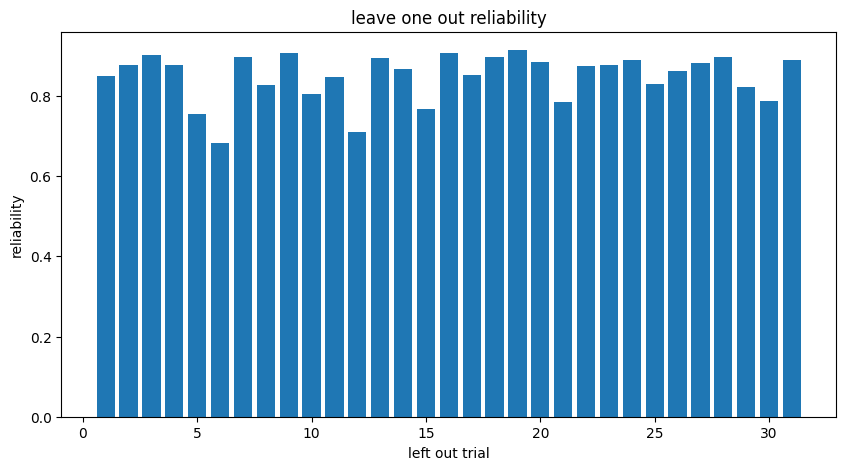

In [12]:
reliability = []
for i, sub_data in enumerate(sub_byLur):
    other_data = np.delete(sub_byLur, i, axis = 0)
    sub_data_mean = np.mean(sub_data, axis = 1)
    other_mean = np.mean(other_data, axis = (0, 2))
    reliability.append(np.dot(sub_data_mean.T, other_mean) / sub_byLur.shape[1])
    
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(np.arange(1, len(reliability)+1), reliability)
ax.set_xlabel('left out trial')
ax.set_ylabel('reliability')
ax.set_title('leave one out reliability')

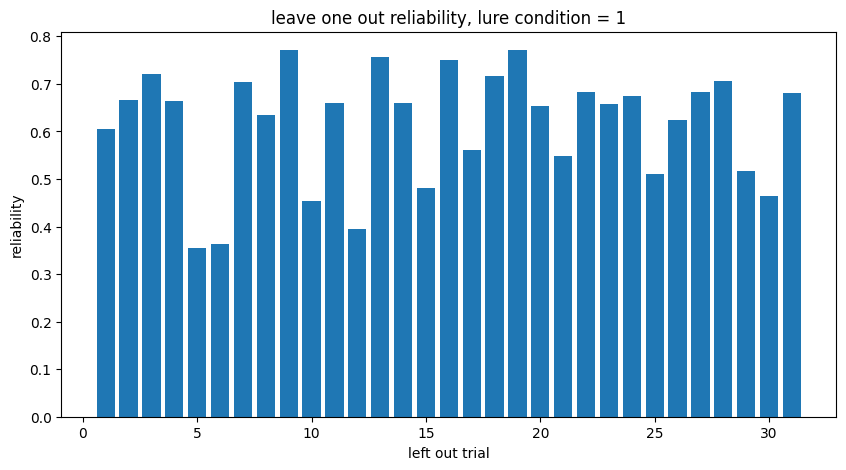

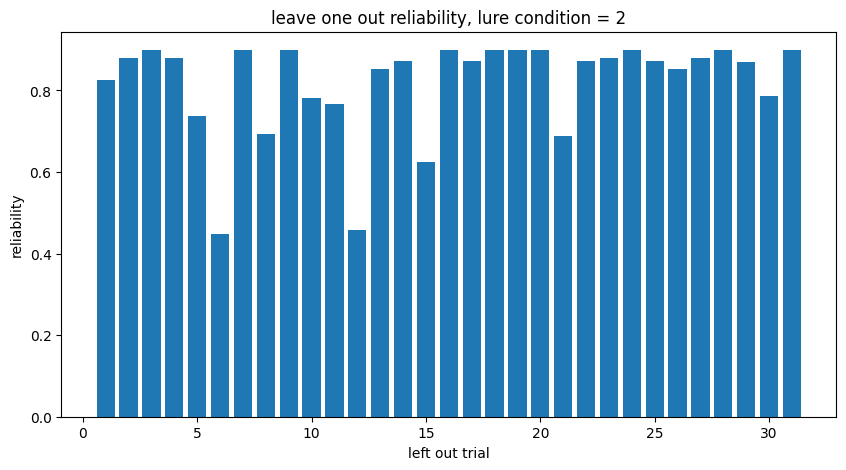

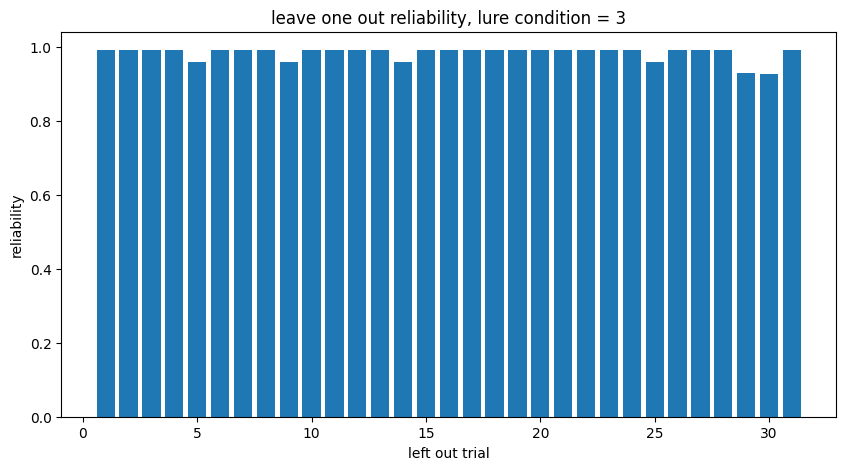

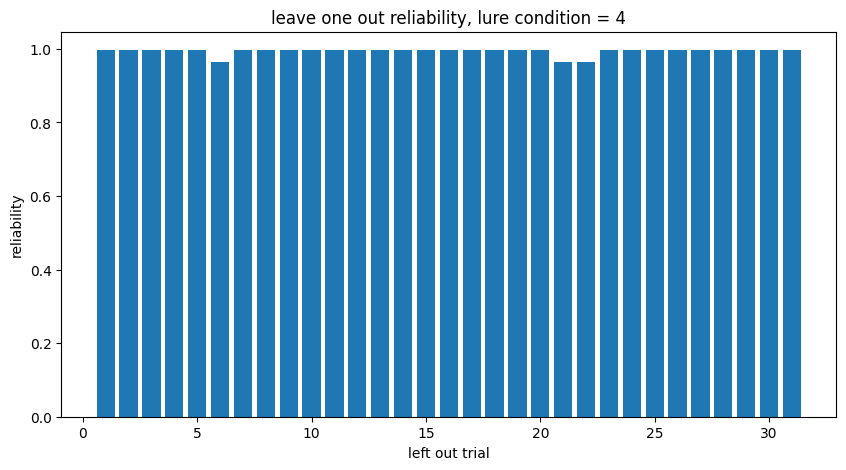

In [13]:
for lur_cond in range(4):
    lur_data = sub_byLur[:, lur_cond, :]
    reliability = []
    for i, sub_data in enumerate(lur_data):
        other_data = np.delete(lur_data, i, axis = 0)
        other_mean = np.mean(other_data, axis = 0)
        reliability.append(np.dot(sub_data.T, other_mean) / lur_data.shape[1])
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.bar(np.arange(1, len(reliability) + 1), reliability)
    ax.set_xlabel('left out trial')
    ax.set_ylabel('reliability')
    ax.set_title('leave one out reliability, lure condition = {}'.format(lur_cond + 1))

[0.9900682181169463, 0.9955163401148427, 0.9993171275408467, 0.9997880198650579]


Text(0.5, 1.0, 'Split-Half Reliability of Subject Responses by Lure Condition')

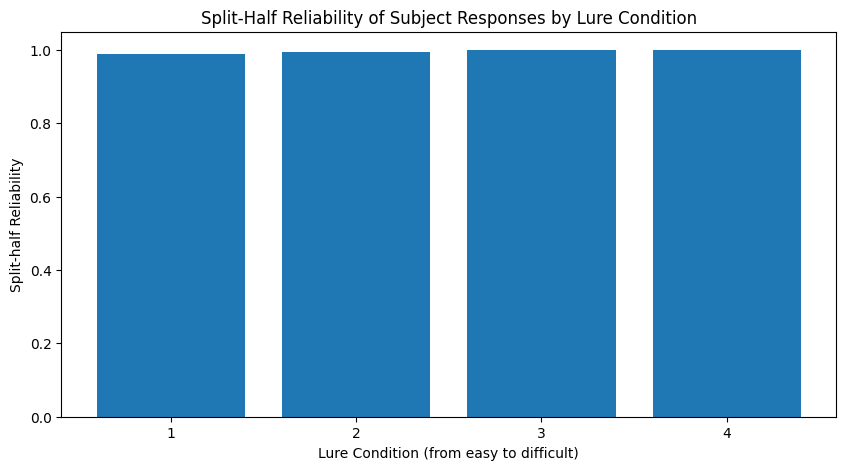

In [39]:
split_reliability = []
for lur_type, lur_data in enumerate(sub_byLur.transpose(1, 0, 2)):
    even_subs = lur_data[::2, :].mean(axis = 0)
    odd_subs = lur_data[1::2, :].mean(axis = 0)
#     split_reliability.append(np.dot(even_subs.T, odd_subs) / len(odd_subs))
    split_reliability.append(np.dot(even_subs.T, odd_subs) / (np.linalg.norm(even_subs) * np.linalg.norm(odd_subs.T)))
print(split_reliability)
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(np.arange(1, len(split_reliability) + 1), split_reliability)
ax.set_xlabel('Lure Condition (from easy to difficult)')
ax.set_xticks([1,2,3,4])
ax.set_ylabel('Split-half Reliability')
ax.set_title('Split-Half Reliability of Subject Responses by Lure Condition')

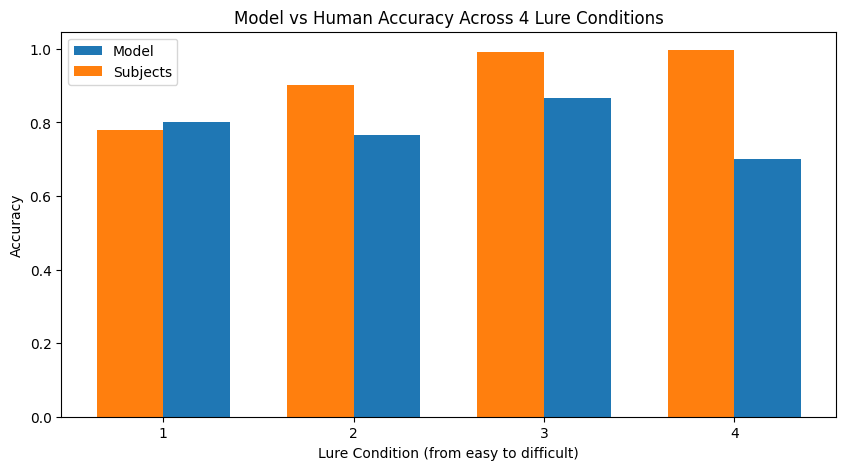

In [24]:
human_lur_acc = sub_byLur.mean(axis = (0, 2))
model_lur_acc = model_byLur.mean(axis = 1)
width = 0.35
x = np.arange(1, len(human_lur_acc) + 1)

fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(x + width/2, model_lur_acc, width, label= 'Model')
ax.bar(x - width/2, human_lur_acc,  width,label= 'Subjects')
ax.set_xlabel('Lure Condition (from easy to difficult)')
ax.set_ylabel('Accuracy')
ax.set_title('Model vs Human Accuracy Across 4 Lure Conditions')
ax.set_xticks([1,2,3,4])
ax.legend()

Text(0.5, 1.0, 'Cosine Similarity Between Models and Subjects (not corrected)')

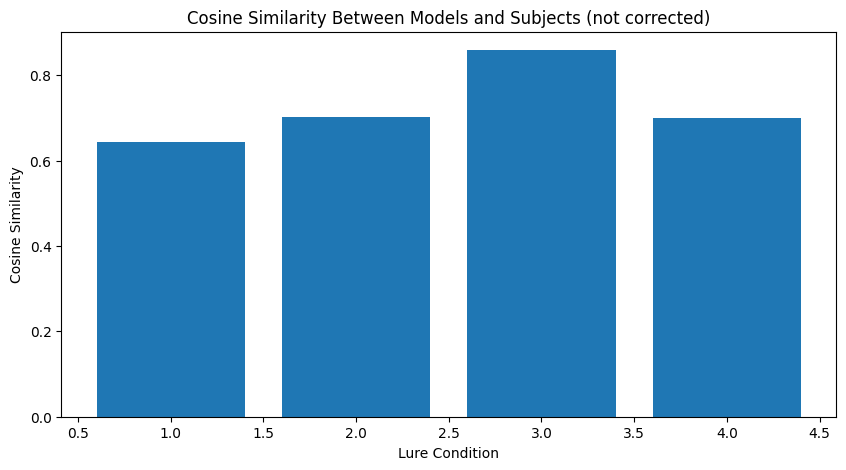

In [35]:
similarity = []
for model_lur, human_lur in zip(model_byLur, sub_byLur.transpose(1, 0, 2)):
    similarity.append(np.dot(model_lur.T, human_lur.mean(axis = 0)) / model_lur.shape[0])
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(np.arange(1, len(similarity) + 1), similarity)
ax.set_xlabel('Lure Condition')
ax.set_ylabel('Cosine Similarity')
ax.set_title('Cosine Similarity Between Models and Subjects (not corrected)')

Text(0.5, 1.0, 'Cosine Similarity between Model and Subjects (normalized by reliability)')

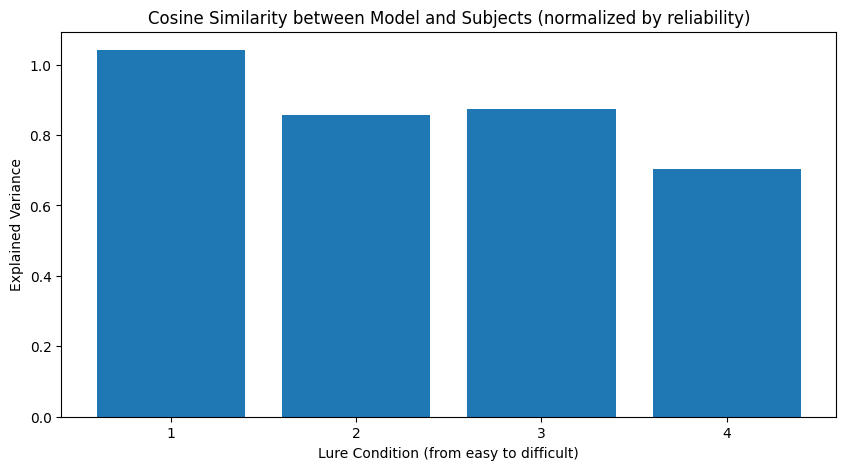

In [36]:
similarity = np.array(similarity)
split_reliability = np.array(split_reliability)
ex_var = similarity / split_reliability
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(np.arange(1, len(ex_var) + 1), ex_var)
ax.set_xlabel('Lure Condition (from easy to difficult)')
ax.set_ylabel('Explained Variance')
ax.set_xticks([1,2,3,4])
ax.set_title('Cosine Similarity between Model and Subjects (normalized by reliability)')